# Projet d'apprentissage en ligne

Ce projet s'appuie sur un article de Elad Hazan, Adam Kalai, Satyen Kale et Amit Agarwal « Logarithmic Regret Algorithms for Online Convex Optimization ». Les auteurs y présentent trois algorithmes permettant de faire de l'optimisation convexe en ligne, en garantissant sous certaines conditions un regret logarithmique à la date $T$. Avec un focntion de perte convexe $f_t$ et une décision $x_t$ à la date $t$, le regret est défini par:
$$ Regret : R_T = \sum\limits_{t=1}^T f_t(x_t) - \underset{x \in K}{\text{min}} \sum\limits_{t=1}^T f_t(x)$$


Les trois algorithmes étudiés dans cet article sont :
- **Online Gradient Descent**
- **Online Newton Step**
- **Exponentially Weighted Online Optimization**

In [2]:
import pandas as pd
from pandas import DataFrame as df
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib inline

In [3]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## Chargement des données

On exploite un jeu de données de sélection de portefeuille. Il s'agit de l'indice boursier S&P 500 pour 490 sociétés, durant 1000 jours de marché de la période 2001 à 2005. Le jeu de données a été obtenu à ce [lien](http://ocobook.cs.princeton.edu/links.htm) au format Matlab puis converti au format CSV.

On cherche donc, au cours du temps, à obtenir le meilleur portefeuille parmi les 490 actions.

In [4]:
data = pd.read_csv("data.csv")
print("Dimensions du DF 'data' : {}".format(data.shape))
data.head()

Dimensions du DF 'data' : (1000, 490)


,AA,AAPL,ABC,ABI,ABK,ABS,ABT,ACE,ACS,A,...,XEL,XL,XLNX,XOM,XRX,XTO,YHOO,YUM,ZION,ZMH
0,27.41,67.82,80.35,27.58,76.69,23.50,37.71,55.50,55.78,35.66,...,18.51,66.38,26.44,58.03,14.20,40.69,40.23,48.79,75.63,62.67
1,27.87,68.10,80.50,27.35,77.00,23.85,38.16,55.86,55.71,35.49,...,18.85,67.57,25.93,58.34,14.17,40.99,40.19,49.10,76.53,62.50
2,27.60,69.66,79.31,27.13,76.15,23.77,38.95,55.39,55.08,35.65,...,18.91,66.57,25.94,58.74,13.99,40.80,41.11,49.10,76.41,61.89
3,27.33,69.34,79.39,27.18,76.49,23.99,38.98,56.05,55.48,35.69,...,18.89,67.42,26.46,60.11,14.16,42.64,42.13,49.05,76.66,61.50
4,26.89,67.11,79.28,27.49,77.54,24.42,38.99,56.28,55.40,35.65,...,18.79,73.74,26.36,59.87,14.19,42.35,42.50,49.60,76.23,62.12


# A completer le traitement effectuer sur les données

In [5]:
prixFull = data.copy().iloc[1:data.shape[0],]
for i in range(0, prixFull.shape[0]) :
    prixFull.iloc[i, ] = data.iloc[i+1, ] / data.iloc[i, ]
prixFull = prixFull.reset_index(drop = True)
print("Dimensions du DF 'prixFull' : {}".format(prixFull.shape))
prixFull.head()

Dimensions du DF 'prixFull' : (999, 490)


,AA,AAPL,ABC,ABI,ABK,ABS,ABT,ACE,ACS,A,...,XEL,XL,XLNX,XOM,XRX,XTO,YHOO,YUM,ZION,ZMH
0,1.016782,1.004129,1.001867,0.991661,1.004042,1.014894,1.011933,1.006486,0.998745,0.995233,...,1.018368,1.017927,0.980711,1.005342,0.997887,1.007373,0.999006,1.006354,1.011900,0.997287
1,0.990312,1.022907,0.985217,0.991956,0.988961,0.996646,1.020702,0.991586,0.988691,1.004508,...,1.003183,0.985201,1.000386,1.006856,0.987297,0.995365,1.022891,1.000000,0.998432,0.990240
2,0.990217,0.995406,1.001009,1.001843,1.004465,1.009255,1.000770,1.011916,1.007262,1.001122,...,0.998942,1.012769,1.020046,1.023323,1.012152,1.045098,1.024811,0.998982,1.003272,0.993698
3,0.983900,0.967840,0.998614,1.011405,1.013727,1.017924,1.000257,1.004103,0.998558,0.998879,...,0.994706,1.093741,0.996221,0.996007,1.002119,0.993199,1.008782,1.011213,0.994391,1.010081
4,0.992934,0.991208,0.999622,0.994907,0.985040,1.007371,1.008464,0.980455,1.006318,0.997756,...,0.984566,0.979116,1.003035,0.996492,0.991543,1.016057,0.996706,0.991532,0.997770,1.004185


# justification de la reduction de dimention

In [9]:
### Réduction de la dimension  
prix = prixFull.iloc[:, 0:10]
prix.head()

,AA,AAPL,ABC,ABI,ABK,ABS,ABT,ACE,ACS,A
0,1.016782,1.004129,1.001867,0.991661,1.004042,1.014894,1.011933,1.006486,0.998745,0.995233
1,0.990312,1.022907,0.985217,0.991956,0.988961,0.996646,1.020702,0.991586,0.988691,1.004508
2,0.990217,0.995406,1.001009,1.001843,1.004465,1.009255,1.000770,1.011916,1.007262,1.001122
3,0.983900,0.967840,0.998614,1.011405,1.013727,1.017924,1.000257,1.004103,0.998558,0.998879
4,0.992934,0.991208,0.999622,0.994907,0.985040,1.007371,1.008464,0.980455,1.006318,0.997756


In [11]:
np.ones(prix.shape[1])/prix.shape[1]

array([ 0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1])

## Définition d'une fonctionde perte

A chaque étape $t$, on choisit un portefeuille d'actions $x_t \in \mathbb{R}^{490}$. La valeur des indices $a_t$ à chaque période est donnée par l'accroissement $c_t = \frac{a_{t+1}}{a_t}$. L'investisseur subit une perte logarithmique $\mathcal{L}(x_t) = -\log(x_t^Tc_t)$.

On choisit de normer l'ensemble des placements à $1$. Les décisions possibles appartiennent donc au simplexe $K = \{x \in \mathbb{R}_+^{490} \text{ tq } x^Tu = 1\}$ où le vecteur $u$ n'est composé que de $1$. On définit la fonction de projection sur cet ensemble.

## Algorithme de la descente de gradient en ligne

Descente de gradient dans le cadre ** en ligne**. 

Pas : $\eta_1, ..., \eta_T$ avec $\eta_t=\frac{1}{H(t+1)}$

>  Etape 1: On choisit arbitrirment $x_1$

> Etape 2: Pour tout $t>1$: on 
>> $x_{t+1} = \Pi_K(x_t - \eta_{t+1} \nabla f_t (x_t))$



 >>avec $\Pi_K(y)$: une projection sur $K$, 
$\Pi_K(y) = \underset{x \in K}{\text{argmin}} ||x-y||$

In [68]:
import cvxpy as cvx
import numpy as np
 
def projectionSimplexe(y):
    d = len(y)
    u = np.ones(d)
    x = cvx.Variable(d)
    obj = cvx.Minimize(cvx.sum_squares(x - y))
    constr = [x >= 0, u*x == 1]
    prob = cvx.Problem(obj, constr)
    prob.solve()
 
    return np.array(x.value).squeeze().tolist()

In [20]:
import math

def Loss(x, c):
    return -math.log((x * c).sum())

def Gradient(x, c):
    scalarProd = (x * c).sum()
    return -c / scalarProd

In [101]:
def OnlineGradientDescent(df, init, H = 0.01):  
    x_t_normalise= projectionSimplexe(init) 
    new_x_t=[x_t_normalise]
    loss = []
    prediction= []
    for i in range(df.shape[0]-1):
        c = df.iloc[i, ]
        eta_t=1/(H*(i+1))
        new_x_t += [projectionSimplexe((new_x_t[i] - eta_t * Gradient(new_x_t[i], c)).tolist())]
        c = df.iloc[i+1, ]
        loss += [Loss(new_x_t[i+1], c) ]
    res = dict()
    res["prediction"] = new_x_t
    res["loss"] = loss
    return(res)

ogdResult = OnlineGradientDescent(prix, np.ones(prix.shape[1])/prix.shape[1])

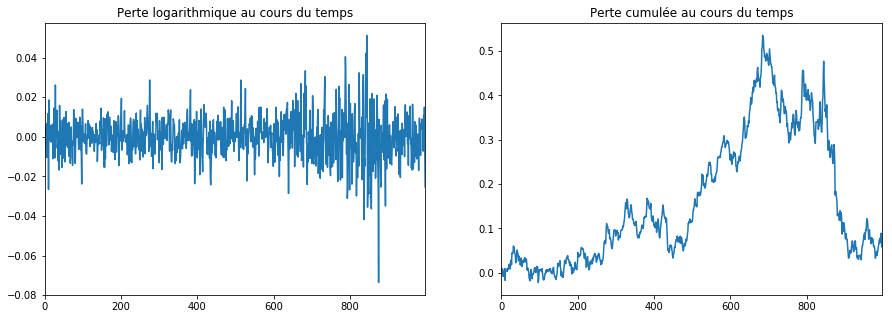

In [102]:
ogdError = ogdResult["loss"]

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
pd.Series(ogdError).plot()
plt.title("Perte logarithmique au cours du temps")
plt.subplot(1,2,2)
pd.Series(np.cumsum(ogdError)).plot()
plt.title("Perte cumulée au cours du temps")
plt.show()

## Algorithme de Newton en ligne

Descente de gradient dans le cadre ** en ligne**. 


>  Etape 1: On choisit arbitrirment $x_1$

> Etape 2: Pour tout $t>1$: on a

>> $$\Delta_{t-1}=\Delta f_{t-1}(x_{t-1})$$

>> $$A_{t-1}= \sum_{\tau=1}^{t-1}\Delta_{\tau}\Delta_{\tau}^T$$


>> $$b_{t-1}= \sum_{\tau=1}^{t-1}\Delta_{\tau}\Delta_{\tau}^T x_\tau- \frac{1}{\beta}\Delta_{\tau}$$



>> $$x_{t+1} = \Pi_K^{A_{t-1}}(A_{t-1}b_{t-1})$$



 >>avec $\Pi_K^{A_{t-1}}(y)$: une projection sur $K$, 
$$\Pi_K^{A_{t-1}}(y) = \underset{x \in K}{\text{argmin}} (x-y)^T A_{t-1}(x-y)$$

In [109]:
def projectionSelonMatrice(A, y) :
    d = len(y)
    u = np.ones(d)
    x = cvx.Variable(d)
    obj = cvx.Minimize(cvx.quad_form(x - y, A))
    constr = [x >= 0, u*x == 1]
    prob = cvx.Problem(obj, constr)
    prob.solve()
 
    return np.array(x.value).squeeze()

def OnlineNewtonStep(df, init, beta = 0.01):
    start = time.time()
    print("--- ALGORITHME ONLINE NEWTON STEP")
    n, p = df.shape
    portfolio = [ init ]
    loss = []
    A = np.zeros((p, p))
    b = np.zeros(p)
    print("--- Nombre d'itérations : {}".format(n))
    it10pct = n // 10
    for i in range(n-1):
        c = df.iloc[i, ]
        delta = Gradient(portfolio[i], c).values.reshape(p, 1)
        Anew = np.dot(delta, np.transpose(delta))
        delta = np.transpose(delta)[0]
        bNew = np.dot(Anew, portfolio[i]) - delta / beta
        A += Anew
        b += bNew
        portfolio += [ projectionSelonMatrice(A, np.dot(np.linalg.pinv(A), b)) ]
        c = df.iloc[i+1, ]
        loss += [ Loss(portfolio[i+1], c) ]
        if i % it10pct == 0:
            print("----- {}% de l'algorithme".format((i // it10pct) * 10))
        
    print(" --- FIN DE L'ALGORITHME")
    print(" --- Temps écoulé : {} secondes".format(time.time() - start))
    res = dict()
    res["prediction"] = portfolio
    res["loss"] = loss
    return(res)

onsResult = OnlineNewtonStep(prix, np.ones(prix.shape[1])/prix.shape[1])

--- ALGORITHME ONLINE NEWTON STEP
--- Nombre d'itérations : 999
----- 0% de l'algorithme
----- 10% de l'algorithme
----- 20% de l'algorithme
----- 30% de l'algorithme
----- 40% de l'algorithme
----- 50% de l'algorithme
----- 60% de l'algorithme
----- 70% de l'algorithme
----- 80% de l'algorithme
----- 90% de l'algorithme
----- 100% de l'algorithme
 --- FIN DE L'ALGORITHME
 --- Temps écoulé : 27.047036170959473 secondes


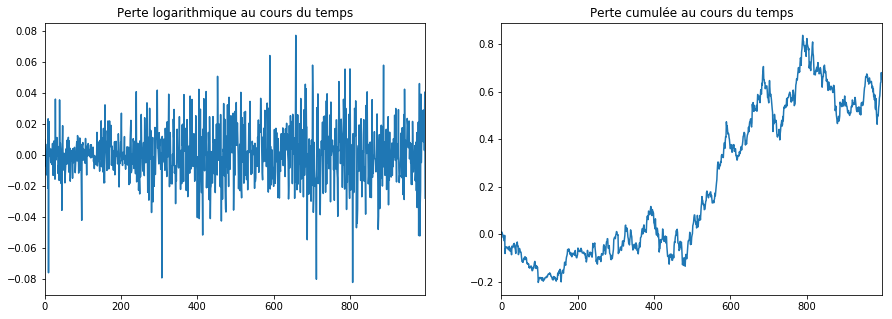

In [110]:
onsError = onsResult["loss"]

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
pd.Series(onsError).plot()
plt.title("Perte logarithmique au cours du temps")
plt.subplot(1,2,2)
pd.Series(np.cumsum(onsError)).plot()
plt.title("Perte cumulée au cours du temps")
plt.show()

## Optimisation en ligne avec poids exponentiels

On commence par introduire une marche aléatoire permettant d'échantillonner selon $w$.

Généralisation de l'algorithme $EWA$ au cas continu.


 >> Etape 1: Poids exponentiels $w_{t+1}(x) = e^{-\alpha\sum\limits_{\tau = 1}^{t} f_{\tau}(x)} = \prod\limits_{\tau = 1}^{t} h_{\tau}(x)$
 
 


>> Etape 2:Mise à jour $x_{t+1} = \frac{\int_K x w_{t+1}(x)dx}{\int_K w_{t+1}(x)dx}$




In [112]:
import random

def computeWeight(alpha, df, t, x):
    subDf = df.iloc[0:t,]
    prod = np.dot(subDf, x)
    # print("sous-DF : {} - x : {} - prod : {}".format(subDf.shape, x.shape, prod.shape))
    res = math.exp(-alpha * prod.sum())
    return(res)

def randomWalk(alpha, df, t, delta):
    n = df.shape[1]
    x = np.ones(n) / n
    currentLkh = computeWeight(alpha, df, t, x)
    nbIt = 10 * df.shape[1]
    
    for i in range(nbIt):
        j = np.random.choice([k for k in range(n-1)])
        X = np.random.choice([-1,1])
        y = x.copy()
        y[j] = y[j] + X*delta
        y[n-1] = y[n-1] - X*delta
        newLkh = computeWeight(alpha, df, t, y)
        proba = min(1, currentLkh / newLkh)
        if np.random.binomial(1, proba) == 1 :
            x = y.copy()
            currentLkh = newLkh
    return x

def portfolioExponentiallyWeighted(df, init, alpha = 0.01, delta = 0.01):
    start = time.time()
    print("--- ALGORITHME EXPONENTIALLY WEIGHTED")
    n = df.shape[0]
    portfolio = [ init ]
    loss = []
    print("--- Nombre d'itérations : {}".format(n))
    it10pct = n // 10
    for i in range(n-1):
        c = df.iloc[i, ]
        
        portfolio += [ randomWalk(alpha, df, i, delta) ]
        c = df.iloc[i+1, ]
        loss += [ logLoss(portfolio[i+1], c) ]
        if i % it10pct == 0:
            print("----- {}% de l'algorithme".format((i // it10pct) * 10))
        
    print(" --- FIN DE L'ALGORITHME")
    print(" --- Temps écoulé : {} secondes".format(time.time() - start))
    res = dict()
    res["prediction"] = portfolio
    res["loss"] = loss
    return(res)
    

ewooResult = portfolioExponentiallyWeighted(prix, np.ones(prix.shape[1])/prix.shape[1])

--- ALGORITHME EXPONENTIALLY WEIGHTED
--- Nombre d'itérations : 999
----- 0% de l'algorithme
----- 10% de l'algorithme
----- 20% de l'algorithme
----- 30% de l'algorithme
----- 40% de l'algorithme
----- 50% de l'algorithme
----- 60% de l'algorithme
----- 70% de l'algorithme
----- 80% de l'algorithme
----- 90% de l'algorithme
----- 100% de l'algorithme
 --- FIN DE L'ALGORITHME
 --- Temps écoulé : 97.82040596008301 secondes


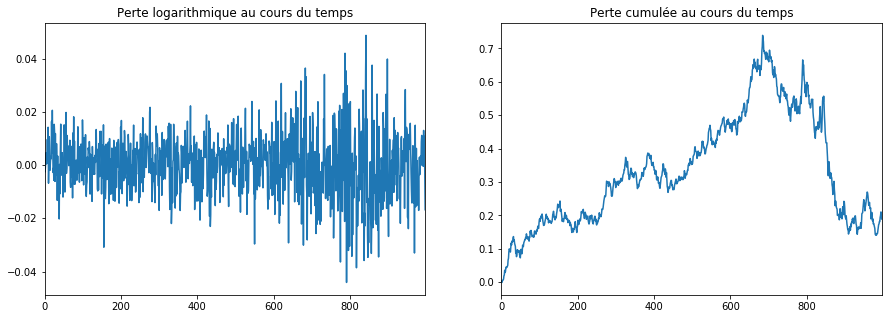

In [113]:
ewooError = ewooResult["loss"]

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
pd.Series(ewooError).plot()
plt.title("Perte logarithmique au cours du temps")
plt.subplot(1,2,2)
pd.Series(np.cumsum(ewooError)).plot()
plt.title("Perte cumulée au cours du temps")
plt.show()